In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.models.video import r3d_18
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset class for loading videos using OpenCV
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, transform=None, num_frames=16):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform
        self.num_frames = num_frames  # Number of frames to sample from each video

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        label = self.labels[idx]

        # Read video using OpenCV
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, self.num_frames, dtype=int)

        for i in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            # Only collect frames at the specified indices
            if i in frame_indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)  # Convert BGR to RGB
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)

        cap.release()

        # Ensure we have the correct number of frames
        if len(frames) != self.num_frames:
            # If not enough frames, pad with zeros
            padding = self.num_frames - len(frames)
            frames += [torch.zeros_like(frames[0])] * padding

        video_tensor = torch.stack(frames).permute(1, 0, 2, 3)  # Rearrange to CxTxHxW
        return video_tensor, label

# Prepare dataset
data_dir = '/kaggle/input/sign-video/Sign Language Dataset'
classes = sorted(os.listdir(data_dir))
video_files = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(data_dir, class_name)
    for video in os.listdir(class_folder):
        video_path = os.path.join(class_folder, video)
        video_files.append(video_path)
        labels.append(class_idx)

# Split the dataset into 80% training and 20% testing
train_videos, test_videos, train_labels, test_labels = train_test_split(video_files, labels, test_size=0.2, stratify=labels, random_state=42)

# Data transformations (resize, crop, tensorize, normalize)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
])

# Create datasets
train_dataset = VideoDataset(train_videos, train_labels, transform=transform)
test_dataset = VideoDataset(test_videos, test_labels, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 181MB/s]


Epoch [1/10], Train Loss: 2.6391, Train Accuracy: 14.49%, Validation Loss: 23.1515, Validation Accuracy: 7.87%


Epoch [2/10], Train Loss: 1.7407, Train Accuracy: 44.16%, Validation Loss: 2.7201, Validation Accuracy: 24.16%


Epoch [3/10], Train Loss: 1.0307, Train Accuracy: 65.12%, Validation Loss: 2.7385, Validation Accuracy: 28.65%


Epoch [4/10], Train Loss: 0.5748, Train Accuracy: 82.00%, Validation Loss: 1.5680, Validation Accuracy: 45.51%


Epoch [5/10], Train Loss: 0.3577, Train Accuracy: 90.58%, Validation Loss: 1.6406, Validation Accuracy: 48.88%


Epoch [6/10], Train Loss: 0.2412, Train Accuracy: 93.95%, Validation Loss: 1.5117, Validation Accuracy: 57.87%


Epoch [7/10], Train Loss: 0.2072, Train Accuracy: 95.50%, Validation Loss: 1.6417, Validation Accuracy: 50.56%


Epoch [8/10], Train Loss: 0.2725, Train Accuracy: 93.95%, Validation Loss: 2.5183, Validation Accuracy: 37.08%


Epoch [9/10], Train Loss: 0.2987, Train Accuracy: 92.41%, Validation Loss: 2.5060, Validation Accuracy: 41.01%


Epoch [10/10], Train Loss: 0.1617, Train Accuracy: 95.50%, Validation Loss: 1.8003, Validation Accuracy: 47.75%


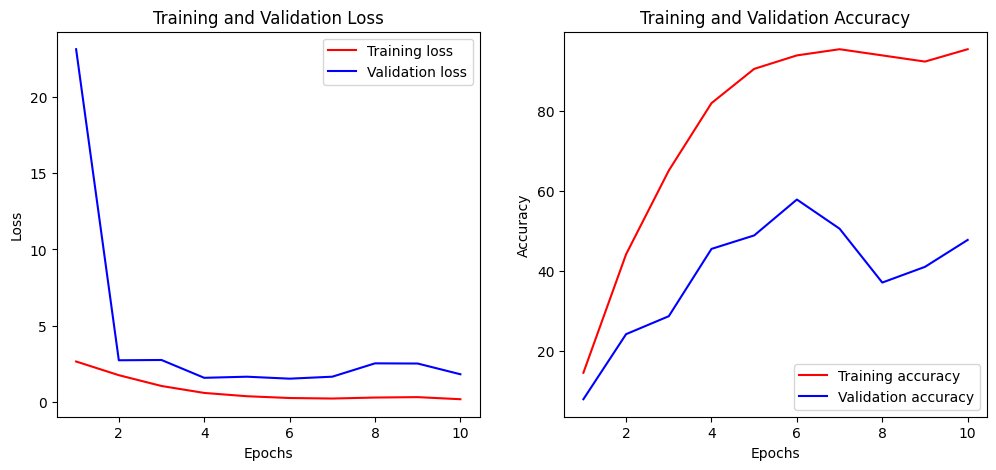

Classification Report:
                     precision    recall  f1-score   support

            ACTING       0.45      0.42      0.43        12
         COMPLAIN        0.57      0.33      0.42        12
         DANGEROUS       1.00      0.20      0.33        10
              DEAF       0.50      0.57      0.53        14
          GOOD_BYE       0.90      0.53      0.67        17
             HELLO       1.00      0.17      0.29        12
        I_LOVE_YOU       0.25      0.11      0.15         9
              MEET       1.00      0.50      0.67        10
            PLEASE       0.67      0.80      0.73        10
PUT_OFF_THE_LIGHT        0.18      0.38      0.24        13
          QUESTION       0.46      0.60      0.52        10
           SECRECY       0.53      0.80      0.64        10
            SEWING       0.50      0.70      0.58        10
             SORRY       1.00      0.44      0.62         9
           SUPPORT       0.54      0.78      0.64         9
            THA

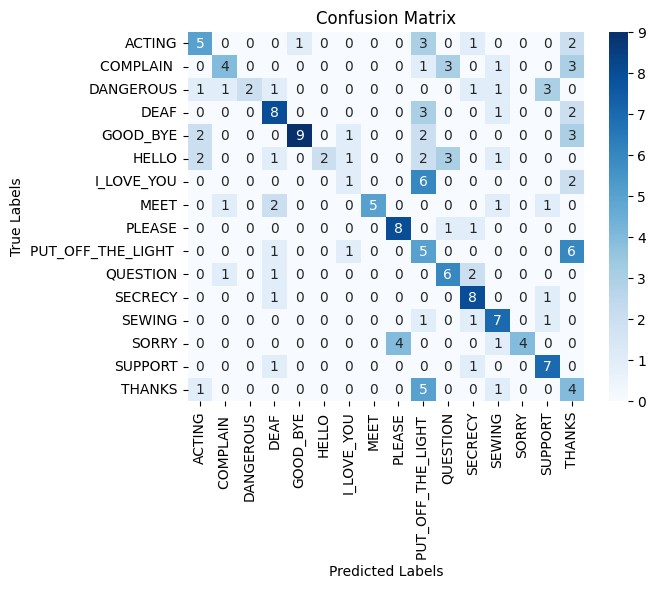

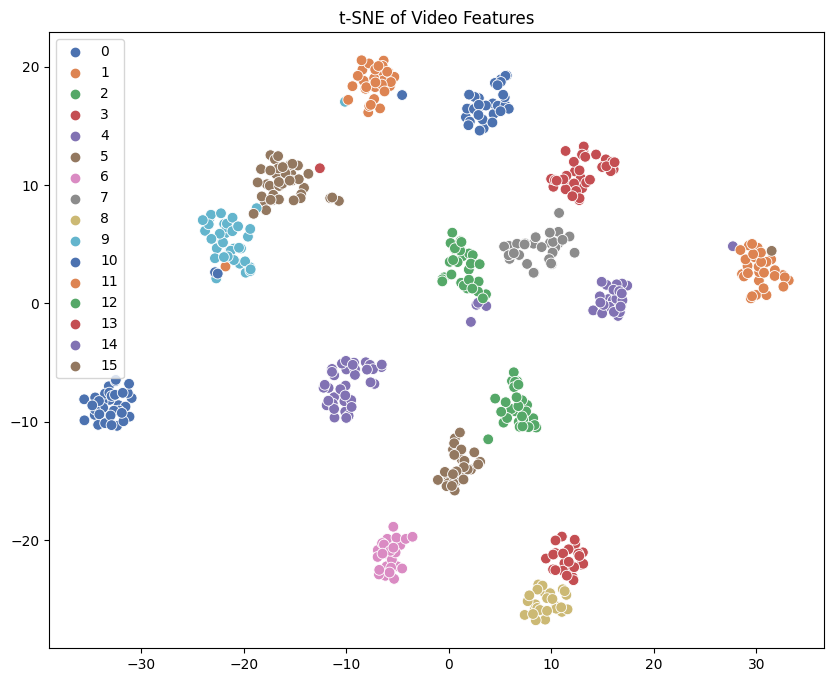

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.video import r3d_18
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Load pre-trained 3D ResNet model
model = r3d_18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 16)  # Modify output layer for 16 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation function with accuracy/loss tracking
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training Loop with tqdm
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Step
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validating', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to plot the accuracy and loss curves
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function to evaluate the model and print the classification report and confusion matrix
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_true, y_pred

# t-SNE Visualization
def tsne_visualization(model, test_loader, device, num_samples=500):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if len(labels) > num_samples:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())

    features = np.vstack(features)
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=labels, palette='deep', s=60)
    plt.title('t-SNE of Video Features')
    plt.show()



# Train the model with validation
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10)

# Plot accuracy and loss curves
plot_curves(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate the model and get classification report and confusion matrix
class_names = sorted(os.listdir(data_dir))  # Assuming class names are folder names
y_true, y_pred = evaluate_model(model, test_loader, device, class_names)


# t-SNE visualization of features
tsne_visualization(model, train_loader, device)

